In [2]:
library('tidyverse')

# install.packages('tidymodels')

library('tidymodels')

# install.packages("arrow")

library(arrow)

NameError: name 'library' is not defined

In [ ]:
# Lire le fichier Parquet depuis le répertoire courant
dataini <- read_parquet("readmission_avc.parquet")

head(dataini)
glimpse(dataini)

# 0. Data Preprocessing

In [ ]:
colSums(is.na(dataini))

apply(is.na(dataini), 2, sum)

map(dataini, ~sum(is.na(.)))

In [ ]:
dataset<-
    dataini%>%
    filter(!is.na(id_D))%>%
    mutate(target = as.factor(if_else(id_D == '',  0 ,  1)))%>%
    mutate_at(c('modeEntree', 'modeSortie', 'sexe'), as.character)%>%
    mutate(nbda = if_else(is.na(nbda), 0, nbda))%>%
    filter(modeSortie != 9)%>%
    select(-c(id, id_D))

dataset%>%group_by(nbda)%>%summarise(nb = n())

# 1. Data Split : Resample Library
training set, validation set and test set

In [ ]:
set.seed(42)

dataset_split <- initial_split(dataset, strata = target, prop = 0.9)

training <- training(dataset_split)
test_set <- testing(dataset_split)

training_split <- initial_split(training, strata = target, prop = 0.8)

train_set <- training(training_split)
validation_set <- testing(training_split)

cat(dim(test_set), dim(validation_set), dim(test_set))
# cat(dim(training), dim(), dim())

dataset_split

# 2. Features Enginnering : Recipes library
Create a collection of input formulas

In [ ]:
rec_basic = recipe(data = train_set, target~.)

rec_basic

prep(rec_basic)

# juice(prep(rec_basic))
formula(prep(rec_basic))

rec_basic <- recipe(data = train_set, target~.)%>%
    step_impute_mean(age)%>%
    step_impute_mode(sexe)%>%
    step_normalize(age)%>% # StandardScaler()
    # step_scale # StandardScaler(with_mean=False)
    step_dummy(modeEntree)%>%
    step_other(dp, threshold = 0.03)%>%
    step_dummy(dp)

juice(prep(rec_basic))

# More general version 
rec_basic <- recipe(data = train_set, target~.) %>%
    step_impute_mean(all_numeric_predictors())%>%
    step_impute_mode(all_nominal_predictors())%>%
    step_normalize(all_numeric_predictors())%>% # StandardScaler()
    step_other(dp, threshold = 0.03)%>%
    step_other(ghm2, threshold = .01)%>%
    step_dummy(all_nominal_predictors())

head(juice(prep(rec_basic)))

In [ ]:
rec_interaction <- rec_basic%>%
                  step_interact(age~duree~sexe)  

In [ ]:
rec_spline <- rec_interaction%>%
                  step_ns(age)

# 3. Model : Parsnip library

## 3.1 Logistical model and workflow

In [ ]:
log_mod <- logistic_reg()%>%
    set_engine('glm')%>%
    set_mode('classification')

log_wf <- workflow()%>%
    add_recipe(rec_basic)%>%
    add_model(log_mod)

log_fitted <- log_wf%>%fit(train_set)

log_fitted%>%predict(validation_set)
log_fitted%>%predict(validation_set, type = 'prob')

log_pred <- validation_set%>%select('target')%>%
            bind_cols(
                    log_fitted%>%predict(validation_set), 
                    log_fitted%>%predict(validation_set, type = 'prob')
            )

log_pred

## 3.2 RF wf

Cas où fixer le random_state est important :

Comparaison entre modèles Lorsque vous comparez plusieurs modèles (par exemple, RandomForest, Gradient Boosting, SVM, etc.), il est recommandé de fixer le random_state dans les modèles aléatoires comme RandomForest ou Gradient Boosting.
Cela garantit que les scores de validation croisée des modèles aléatoires ne fluctuent pas inutilement, et les comparaisons sont basées uniquement sur leurs performances réelles, et non sur des différences dues au hasard.

In [ ]:
library(ranger)

rf_mod <- rand_forest()%>%
    set_engine('ranger')%>% # Une implémentation rapide et efficace de Random Forest en C++
    set_mode('classification')

rf_mod <- rand_forest(
  trees = tune(),      # Équivalent de n_estimators
  mtry = tune(),      # Équivalent de max_features
  min_n = tune()       # Taille minimale des nœuds terminaux => min_samples_leaf
) %>%
  set_engine("ranger") %>%
  set_mode("classification")

rf_wf <- workflow() %>%
  add_recipe(rec_basic) %>%
  add_model(rf_mod)

# Automatiquement divisé en 5 valeurs
grid_regular(
  trees(range = c(50, 200)),  
  mtry(range = c(2, 10)),
  levels = 5
)

**n_estimators** (Nombre d'arbres dans la forêt)<br/>

Pourquoi le tuner ?<br/>
* Augmenter le nombre d'arbres améliore souvent la performance du modèle (réduit la variance), mais au prix d'une augmentation du temps d'entraînement et d'inférence.
* Par défaut, 100 arbres suffisent souvent, mais augmenter à 200 ou 500 peut être utile pour des datasets complexes.
* Valeurs courantes : 50, 100, 200, 500.

**max_features** (Nombre de features à considérer lors de la division)<br/>
Description : Nombre de features à échantillonner aléatoirement pour rechercher la meilleure division à chaque split.<br/>
* 'sqrt' : 
* 'log2' : 
* Un entier : Un nombre fixe de features.<br/>

Pourquoi le tuner ?
* Moins de features à chaque split réduit la corrélation entre les arbres, ce qui améliore la diversité de la forêt.
* Trop peu de features peuvent limiter la capacité d'apprentissage des arbres.
* Valeurs courantes : 'sqrt', 'log2', 0.3, 0.5 (fraction des features).

**min_samples_leaf** (Nombre mininum d’échantillons par feuille)<br/>
Description : Nombre mininum d'échantillons requis pour qu'un nœud soit une feuille (Le nombre minimum d'individus (ou de lignes) requis pour qu’un nœud soit considéré comme une feuille.).<br/>
Pourquoi le tuner ?<br/>
* Augmenter cette valeur force les feuilles à contenir plus d’échantillons, ce qui réduit le surapprentissage.<br/>
* Cela est particulièrement utile pour les datasets déséquilibrés ou bruités.<br/>

Valeurs courantes : 1 (par défaut), 5, 10, 20.


**max_depth** (Profondeur maximale des arbres)<br/>
Description : Contrôle la profondeur maximale de chaque arbre.

Pourquoi le tuner ?<br/>
* Limiter la profondeur aide à éviter le surapprentissage (overfitting).
* Des arbres très profonds capturent trop de bruit dans les données, tandis que des arbres peu profonds risquent de sous-apprendre (underfitting).

Valeurs courantes :<br/>
* None (par défaut, arbre entièrement développé).
* Valeurs typiques : 5, 10, 20, en fonction de la taille des données.


In [ ]:
rf_grid <- expand.grid(
  trees = c(50, 100, 200),  # Nombre d'arbres
  mtry = c(floor(sqrt(ncol(train_set))), 5),      # Valeurs spécifiques pour mtry
  # max_depth = c(5, 10, 20, NA)  # Valeurs spécifiques pour max_depth
  min_n = c(1, 5, 10) # Taille minimale des nœuds terminaux, Plus cette valeur est grande, plus vos arbres seront "simples" (moins de surapprentissage)
)

print(rf_grid)



In [ ]:
set.seed(42)
cv_splits <- vfold_cv(train_val_set, v = 5, strata = target)

In [ ]:
set.seed(42)
rf_grid_fitted <- tune_grid(
  rf_wf,
  resamples = cv_splits,
  grid = rf_grid,
  metrics = metric_set(accuracy, roc_auc)
)

In [ ]:
floor(log2(ncol(train_set)))

floor(sqrt(ncol(train_set)))

In [ ]:
show_best(rf_grid_fitted, metric = "roc_auc")

best_rf_params = select_best(rf_grid_fitted, metric = "roc_auc")

In [ ]:
all_results <- collect_metrics(rf_grid_fitted)
all_results %>%
  filter(.metric == "roc_auc") %>%
  arrange(desc(mean))

In [ ]:
# Modèle final
final_rf_wf <- finalize_workflow(rf_wf, best_rf_params)
final_rf_fit <- fit(final_rf_wf, data = train_data)

## 3.3 KNN

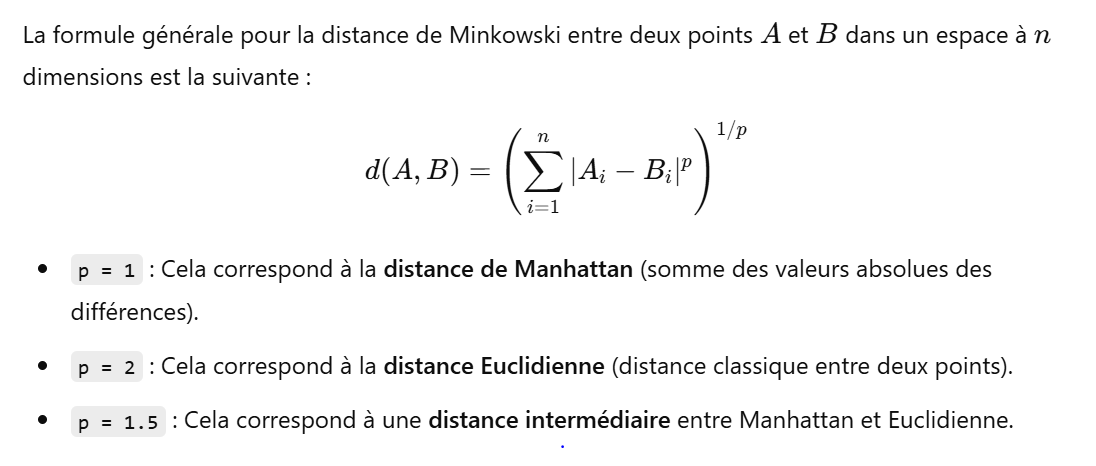

In [ ]:
install.packages("kknn")

library("kknn")

In [ ]:
knn_mod <- nearest_neighbor(
  neighbors = tune(),  # Équivalent de n_neighbors
  weight_func = tune(),  # Équivalent de weights
  dist_power = tune()    # Équivalent de la metric (minkowski, manhattan, euclidean)
) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_wf <- workflow() %>%
  add_recipe(rec_basic) %>%
  add_model(knn_mod)

knn_grid <- grid_regular(
  neighbors(range = c(3, 10)),       
  dist_power(range = c(1, 2)),       
  levels = 5                         
) %>%
  mutate(weight_func = rep(c("rectangular", "inv"), length.out = nrow(.)))

print(knn_grid)

#### Hyperparamètres courants à tuner pour KNN<br/>

**n_neighbors** (Nombre de voisins)<br/>
Description : Définit combien de voisins sont considérés pour prendre une décision.<br/>
Pourquoi le tuner ?<br/>
* Un nombre de voisins trop faible peut rendre le modèle sensible au bruit (overfitting).
* Un nombre trop élevé peut le rendre trop généralisant (underfitting).
<br/>Valeurs courantes : 3, 5, 7, 10, 15.

**weights** (Pondération des voisins)
Description : Définit si tous les voisins contribuent également ou si leur contribution est pondérée par la distance.
'uniform' : Tous les voisins ont le même poids.
'distance' : Les voisins proches ont plus de poids que les voisins éloignés.
Pourquoi le tuner ? <br/>
La pondération par distance peut améliorer la performance si les observations proches sont plus représentatives de la classe cible.
Valeurs courantes : 'uniform', 'distance'.


**metric** (Distance utilisée pour trouver les voisins)
Description : Définit la mesure de distance utilisée pour calculer la proximité entre les points.
* 'minkowski' : Distance généralisée.
* 'euclidean' : Distance euclidienne
* 'manhattan' : Distance Manhattan

Pourquoi le tuner ?<br/>
Certaines mesures de distance peuvent mieux capturer la structure des données en fonction du problème.
Valeurs courantes : 'euclidean', 'manhattan', 'minkowski'.


In [ ]:
# dist_power = 1, la distance de Minkowski devient équivalente à la distance de Manhattan
# dist_power = 2, vous utilisez la distance Euclidienne

knn_grid_fitted <- tune_grid(
    knn_wf,
    resamples = cv_splits,
    grid = knn_grid,
    metrics = metric_set(accuracy, roc_auc, f_meas),
    control = control_grid(save_pred =  TRUE)
)

In [ ]:
show_best(knn_grid_fitted, metric = "roc_auc")
select_best(knn_grid_fitted, metric = "roc_auc")

## 3.4 penalized regression

In [ ]:
install.packages('glmnet')

library(glmnet)

In [ ]:
# install.packages('glmnet')

library(glmnet)

pena_mod <- 
    logistic_reg(penalty = tune(), mixture = tune()) %>%
    set_engine("glmnet")

pena_wf <- workflow() %>%
  add_recipe(rec_basic) %>%
  add_model(pena_mod)

ridge_grid <- expand.grid(
  penalty = c(100, 10, 1, 0.1, 0.01, 0.001),  # 1 / C = 10, 100, 1000
  mixture = 0                     # Ridge (L2)
)

lasso_grid <- expand.grid(
  penalty = c(100, 10, 1, 0.1, 0.01, 0.001),  # 1 / C = 10, 100, 1000
  mixture = 1                     # Lasso (L1)
)


elastic_net_grid <- expand.grid(
  penalty = c(100, 10, 1, 0.1, 0.01, 0.001),  # 1 / C = 10, 100, 1000
  mixture = c(0.1, 0.5, 0.9)      # l1_ratio
)


pena_grid <- bind_rows(
  ridge_grid,
  lasso_grid,
  elastic_net_grid
)

In [ ]:
print(pena_grid)

In [ ]:
# Rechercher les meilleurs hyperparamètres
pena_grid_fitted <- tune_grid(
  pena_wf,
  resamples = cv_splits,
  grid = pena_grid,
  metrics = metric_set(roc_auc, accuracy) # Mesurer la performance avec AUC
)



In [ ]:
# Voir les meilleurs résultats
show_best(pena_grid_fitted, metric = "roc_auc")

select_best(rf_grid_fitted, metric = "roc_auc")

## 3.5 xgboost 
Il semble que c'est xg qui marche au mieux

In [ ]:
install.packages('xgboost')
library('xgboost')

In [ ]:

gb_mod <- boost_tree(
  trees = tune(),            # Nombre d'arbres (équivalent de `n_estimators`)
  learn_rate = tune(),       # Taux d'apprentissage (`learning_rate`)
  tree_depth = tune()        # Profondeur maximale des arbres (`max_depth`)
) %>%
  set_engine("xgboost", set.seed = 42) %>%
  set_mode("classification")


gb_wf <- workflow() %>%
  add_recipe(rec_basic) %>%
  add_model(gb_mod)

gb_grid <- expand_grid(
  trees = c(300, 500),
  learn_rate = c(0.01, 0.05, 0.1, 0.2),
  tree_depth = c(3, 5, 7)
)
print(gb_grid)

**learning_rate** <br/>
Description : Le Gradient Boosting construit les arbres séquentiellement : chaque nouvel arbre est formé pour corriger les erreurs faites par les arbres précédents. À chaque étape, le nouvel arbre ajuste les résidus (erreurs) des prédictions précédentes.Le learning_rate contrôle la contribution de chaque nouvel arbre à la prédiction globale 𝐹 𝑡 ( 𝑥 )<br/>
Importance : Très élevé.<br/>
* Un taux d'apprentissage faible (ex. : 0.01) nécessite plus d'arbres (n_estimators) pour atteindre des performances optimales.
* Un taux élevé (ex. : 0.2 ou 0.3) permet une convergence rapide, mais risque de sur-apprendre.
* Valeur par défaut : 0.1.
* Valeurs courantes : [0.01, 0.05, 0.1, 0.2].


**n_estimators**<br/>
Description : Nombre total d'arbres dans le modèle. A chaque itération, un seul arbre est ajouté au modèle<br/>
Importance : Très élevé.
* Un nombre insuffisant d'arbres peut sous-apprendre, tandis qu'un nombre trop élevé peut augmenter le temps d'entraînement sans amélioration significative.
* Valeur par défaut : 100.
* Valeurs courantes : [100, 200, 500, 1000], dépendant de la taille des données et de learning_rate.

**max_depth**<br/>
Description : Profondeur maximale de chaque arbre.<br/>
Importance : Élevée.
* Limiter la profondeur empêche les arbres de surapprendre en capturant trop de bruit.
* Une profondeur trop faible peut sous-apprendre les relations complexes dans les données.
* Valeur par défaut : 3.
* Valeurs courantes : [3, 5, 7, None].

**min_samples_split**<br/>
Description : Nombre mininum d'échantillons requis pour diviser un nœud.<br/>
Importance : Moyen.<br/>
* Permet de contrôler la taille minimale des nœuds parents, ce qui limite les arbres très complexes.
* Valeur par défaut : 2.
* Valeurs courantes : [2, 5, 10].

**min_samples_leaf** <br/>
Description : Nombre mininum d'échantillons requis pour être dans une feuille.<br/>
Importance : Moyen.<br/>
* Empêche les arbres de créer des feuilles contenant un très petit nombre de données, ce qui peut les rendre sensibles au bruit.
* Valeur par défaut : 1.
* Valeurs courantes : [1, 5, 10, 20].

In [ ]:
gb_grid_fitted = tune_grid(
    gb_wf,
    grid=  gb_grid,
    resamples = cv_splits,
    metrics = metric_set(roc_auc, f_meas, accuracy),
    control = control_grid(save_pred = TRUE)
)

In [ ]:
show_best(gb_grid_fitted, metric = "roc_auc")

select_best(gb_grid_fitted, metric = "roc_auc")

## 3.6 SVM

svm_linear() : pour les SVM avec noyau linéaire.
svm_rbf() : pour les SVM avec noyau RBF (Radial Basis Function).
svm_poly() : pour les SVM avec noyau polynomial.

In [ ]:
install.packages('kernlab')

library(kernlab)

# Définir le modèle
svm_poly_mod <- svm_poly(
  cost = tune(),       # Paramètre C à tuner
  degree = tune()      # Degré du noyau polynomial à tuner
) %>%
  set_engine("kernlab") %>%
  set_mode("classification")



# Workflow
svm_poly_wf <- workflow() %>%
  add_model(svm_poly_mod) %>%
  add_recipe(rec_basic)

# Grille d'hyperparamètres
svm_poly_grid <- tidyr::expand_grid(
  cost = c(0.1, 1, 10, 100),  # Valeurs spécifiques pour C
  degree = c(2, 3, 4)         # Valeurs spécifiques pour degree
)




In [ ]:
class(svm_poly_results)

svm_poly_results <- tune_grid(
  svm_poly_wf,
  resamples = cv_splits,
  grid = svm_poly_grid,
  metrics = metric_set(roc_auc, accuracy)
)

show_best(svm_poly_results, metric = "roc_auc")

select_best(svm_poly_results, metric = "roc_auc")



## 3.7 MLP

In [ ]:
# install.packages('nnet')
library(nnet)

# Définir le modèle MLP
mlp_mod <- mlp(
  hidden_units = tune(),    # Nombre de neurones dans la couche cachée
  penalty = tune(),         # Coefficient de régularisation L2
  epochs = tune()           # Nombre d'itérations
) %>%
  set_engine("nnet") %>%    # Utiliser le moteur nnet
  set_mode("classification") # Mode classification (ou regression si nécessaire)

# Afficher la structure du modèle
mlp_mod

# install.packages('tensorflow') 

# install.packages('keras')
# library(tidymodels)
# library(keras)
# library(tensorflow)

# # Définir un modèle MLP avec plusieurs couches cachées
# mlp_keras_mod <- mlp(
#   hidden_units = tune(),  # Neurones dans chaque couche
#   penalty = tune(),       # Régularisation L2
#   epochs = tune()         # Nombre d'itérations
# ) %>%
#   set_engine("keras") %>%
#   set_mode("classification")

mlp_grid <- grid_regular(
  hidden_units(range = c(1, 10)),  # Nombre de neurones cachés
  penalty(range = c(0.001, 0.1)),  # Régularisation L2
  epochs(range = c(50, 200)),      # Nombre d'itérations
  levels = 5                       # Divise les plages en 5 niveaux
)



In [ ]:
mlp_wf <- workflow() %>%
  add_recipe(rec_basic) %>%  # Crée une recette
  add_model(mlp_mod)
  # add_model(mlp_keras_mod)

set.seed(123)
mlp_res <- mlp_wf %>%
  tune_grid(
    resamples = cv_splits,  # 5-fold cross-validation
    grid = mlp_grid,                             # Grille d'hyperparamètres
    metrics = metric_set(roc_auc, accuracy))


collect_metrics(mlp_res)

show_best(mlp_res, metric = "roc_auc", n = 5)

best_params <- select_best(mlp_res, metric = "roc_auc")
print(best_params)

# 4. Workflowset

In [ ]:
# ============================================
# 1. Définir les recettes
# ============================================
recipes <- list(
  basic = rec_basic,
  interaction = rec_interaction,
  spline = rec_spline
)


# ============================================
# 2. Définir les modèles
# ============================================

models <- list(
  gb = gb_mod,
  rf = rf_mod,
  reg = pena_mod,
  mlp_mod
)

# ============================================
# 3. Créer le Workflowset
# ============================================

wf_set <-
  workflow_set(
    preproc = recipes,
    models = models
)

In [ ]:
# ============================================
# 5. Exécuter le tuning pour chaque combinaison
# ============================================


set.seed(24)

wf_set_fitted <- wf_set%>%
  workflow_map(
    resamples = cv_splits,
    metrics = metric_set(roc_auc, accuracy),
    grid = 5,
    # grid = 20,
    fn = 'tune_grid',
    verbose = T
  )

In [ ]:
# ============================================
# 6. Visualiser et analyser les résultats
# ============================================

wf_set_fitted %>%
    rank_results(rank_metric = "roc_auc")%>%
    filter(.metric == "roc_auc") %>%
    arrange(desc(mean))



In [ ]:
autoplot(
    wf_set_fitted,
    rank_metric = "roc_auc", # how to order models
    metric = "roc_auc", # which metric to visualize
    select_best = TRUE # one point per workflow
)


In [ ]:
# ============================================
# 7. Extraire et finaliser le meilleur workflow
# ============================================

res <- wf_set_fitted %>%
    rank_results(rank_metric = "roc_auc")%>%
    filter(.metric == "roc_auc") %>%
    arrange(desc(mean))

res

In [ ]:
results <- wf_set_fitted %>%
  extract_workflow_set_result('basic_gb')

In [ ]:
metrics <- results %>%
  collect_metrics()

# metrics %>%
#   show_best('roc_auc', n = Inf)
best_roc_auc <- metrics %>%
  filter(.metric == "roc_auc") %>%
  summarise(max_roc_auc = max(mean)) %>%
  pull(max_roc_auc)

In [ ]:
best_params <- metrics %>%
  filter(.metric == "roc_auc", mean == best_roc_auc)

best_params

best_roc_auc

In [ ]:
final_workflow <- finalize_workflow(
  extract_workflow(wf_set_fitted, 'basic_gb'),
  best_params
)

In [ ]:
# ============================================
# 8. Ajuster le modèle final et prédire
# ============================================
last_fit <- final_workflow %>%
  last_fit(split = dataset_split)

In [ ]:
# ============================================
# 9. Calculer les métriques finales
# ============================================
# last_fit %>% collect_predictions()

last_fit%>% collect_metrics()

class(last_fit)

## Alernatif à partir de l'étape 7

In [ ]:
# ============================================
# 7. Extraire et finaliser le meilleur workflow
# ============================================
best_results <- wf_set_fitted %>%
  rank_results(rank_metric = "roc_auc") %>%
  filter(.metric == "roc_auc") %>%
  arrange(desc(mean))


best_workflow_id <- best_results$wflow_id[1]  # ID du meilleur workflow

best_workflow <- extract_workflow_set_result(wf_set_fitted, id = best_workflow_id)

best_params <- select_best(best_workflow, metric = "roc_auc")

final_workflow <- finalize_workflow(
  extract_workflow(wf_set_fitted, 'basic_gb'),
  best_params
)

last_fit <- final_workflow %>%
  last_fit(split = dataset_split)

# last_fit %>% collect_predictions()

last_fit%>% collect_metrics()

class(last_fit)

# Annexe 1
## 3 models SVM

In [ ]:
# 1. Définir la recette pour le prétraitement
rec <- recipe(target ~ ., data = train_data) %>%
  step_normalize(all_numeric_predictors())

# ================================
#  SVM avec noyau linéaire
# ================================

# Modèle SVM linéaire
svm_linear_mod <- svm_linear(
  cost = tune()  # Paramètre de régularisation
) %>%
  set_engine("LiblineaR") %>%
  set_mode("classification")

# Workflow SVM linéaire
svm_linear_wf <- workflow() %>%
  add_model(svm_linear_mod) %>%
  add_recipe(rec)

# Grille d'hyperparamètres pour le noyau linéaire
svm_linear_grid <- expand_grid(
  cost = c(0.1, 1, 10, 100)  # Valeurs spécifiques pour C
)

# ================================
#  SVM avec noyau RBF
# ================================

# Modèle SVM RBF
svm_rbf_mod <- svm_rbf(
  cost = tune(),       # Paramètre de régularisation
  rbf_sigma = tune()   # Paramètre gamma
) %>%
  set_engine("kernlab") %>%
  set_mode("classification")

# Workflow SVM RBF
svm_rbf_wf <- workflow() %>%
  add_model(svm_rbf_mod) %>%
  add_recipe(rec)

# Grille d'hyperparamètres pour le noyau RBF
svm_rbf_grid <- expand_grid(
  cost = c(0.1, 1, 10, 100),  # Valeurs spécifiques pour C
  rbf_sigma = c(0.01, 0.1, 1) # Valeurs spécifiques pour gamma
)

# ================================
#  SVM avec noyau polynomial
# ================================

# Modèle SVM polynomial
svm_poly_mod <- svm_poly(
  cost = tune(),       # Paramètre de régularisation
  degree = tune()      # Degré du polynôme
) %>%
  set_engine("kernlab") %>%
  set_mode("classification")

# Workflow SVM polynomial
svm_poly_wf <- workflow() %>%
  add_model(svm_poly_mod) %>%
  add_recipe(rec)

# Grille d'hyperparamètres pour le noyau polynomial
svm_poly_grid <- expand_grid(
  cost = c(0.1, 1, 10, 100),  # Valeurs spécifiques pour C
  degree = c(2, 3, 4)         # Degré du polynôme
)

# ================================
#  Tuning et résultats
# ================================

# Splits de validation croisée
cv_splits <- vfold_cv(train_data, v = 5, strata = target)

# Tuning pour SVM linéaire
svm_linear_results <- tune_grid(
  svm_linear_wf,
  resamples = cv_splits,
  grid = svm_linear_grid,
  metrics = metric_set(roc_auc, accuracy)
)

# Tuning pour SVM RBF
svm_rbf_results <- tune_grid(
  svm_rbf_wf,
  resamples = cv_splits,
  grid = svm_rbf_grid,
  metrics = metric_set(roc_auc, accuracy)
)

# Tuning pour SVM polynomial
svm_poly_results <- tune_grid(
  svm_poly_wf,
  resamples = cv_splits,
  grid = svm_poly_grid,
  metrics = metric_set(roc_auc, accuracy)
)

# ================================
#  Meilleurs résultats
# ================================

# Afficher les meilleurs hyperparamètres pour chaque modèle
show_best(svm_linear_results, metric = "roc_auc")
show_best(svm_rbf_results, metric = "roc_auc")
show_best(svm_poly_results, metric = "roc_auc")
